# Transformers

The transformer architecture is behind the latest revolution in machine learning. It is the breakthrough that enabled the production of large language models such as ChatGPT (OpenAI), Bard/Gemini (Google) and LLaMA (Meta). It also behind other recent breakthroughs in generative AI such as DALL-E. For example, here is a diagram of the neural network architecture from "[Improving Language Understanding
by Generative Pre-Training](https://cdn.openai.com/research-covers/language-unsupervised/language_understanding_paper.pdf)", the paper that introduced ChatGPT:
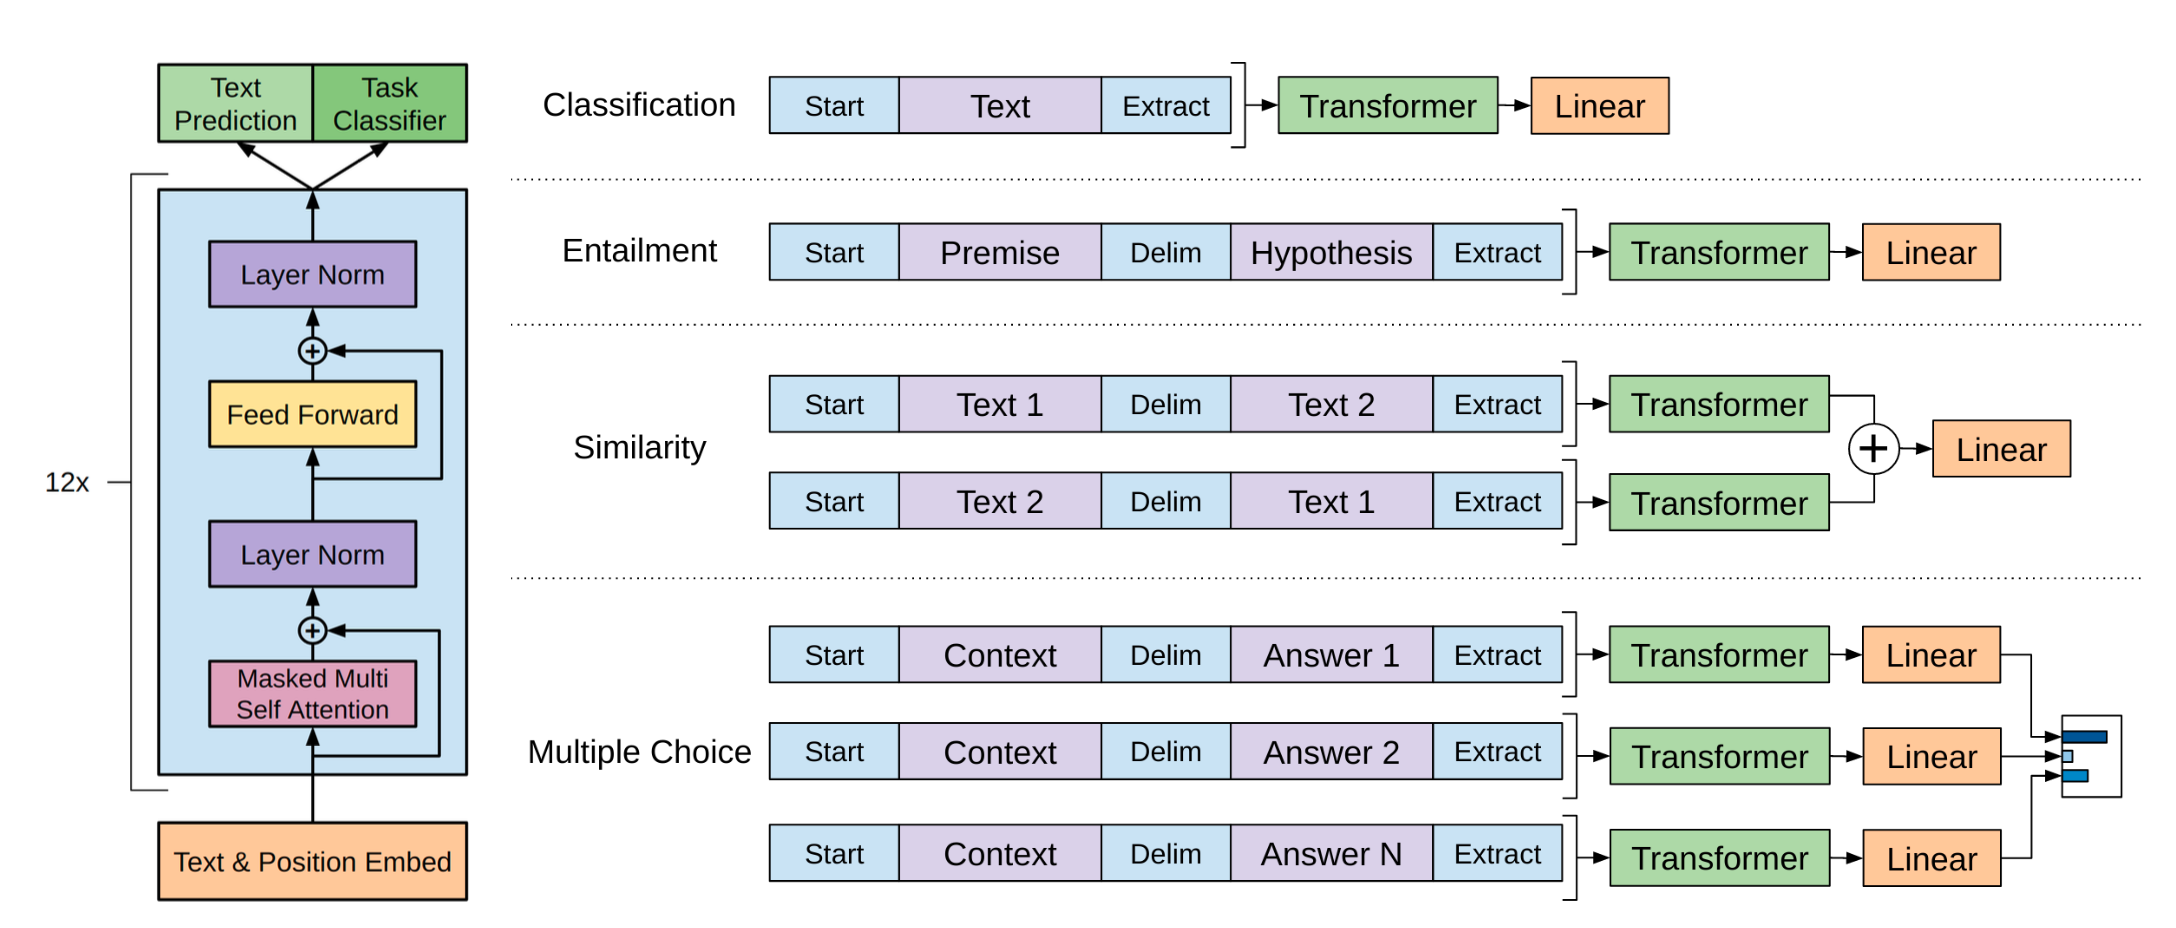
The  blue box on the left is a _Transformer_ layer and is the key to the success of ChatGPT.

## Transformer architecture
The concept of the transformer architecture and transformer layers was popularised in the 2017 paper "[Attention Is All You Need](https://arxiv.org/abs/1706.03762)" produced by researchers at Google. In the paper they proposed the transformer network architecture as given in the below figure:
<div>
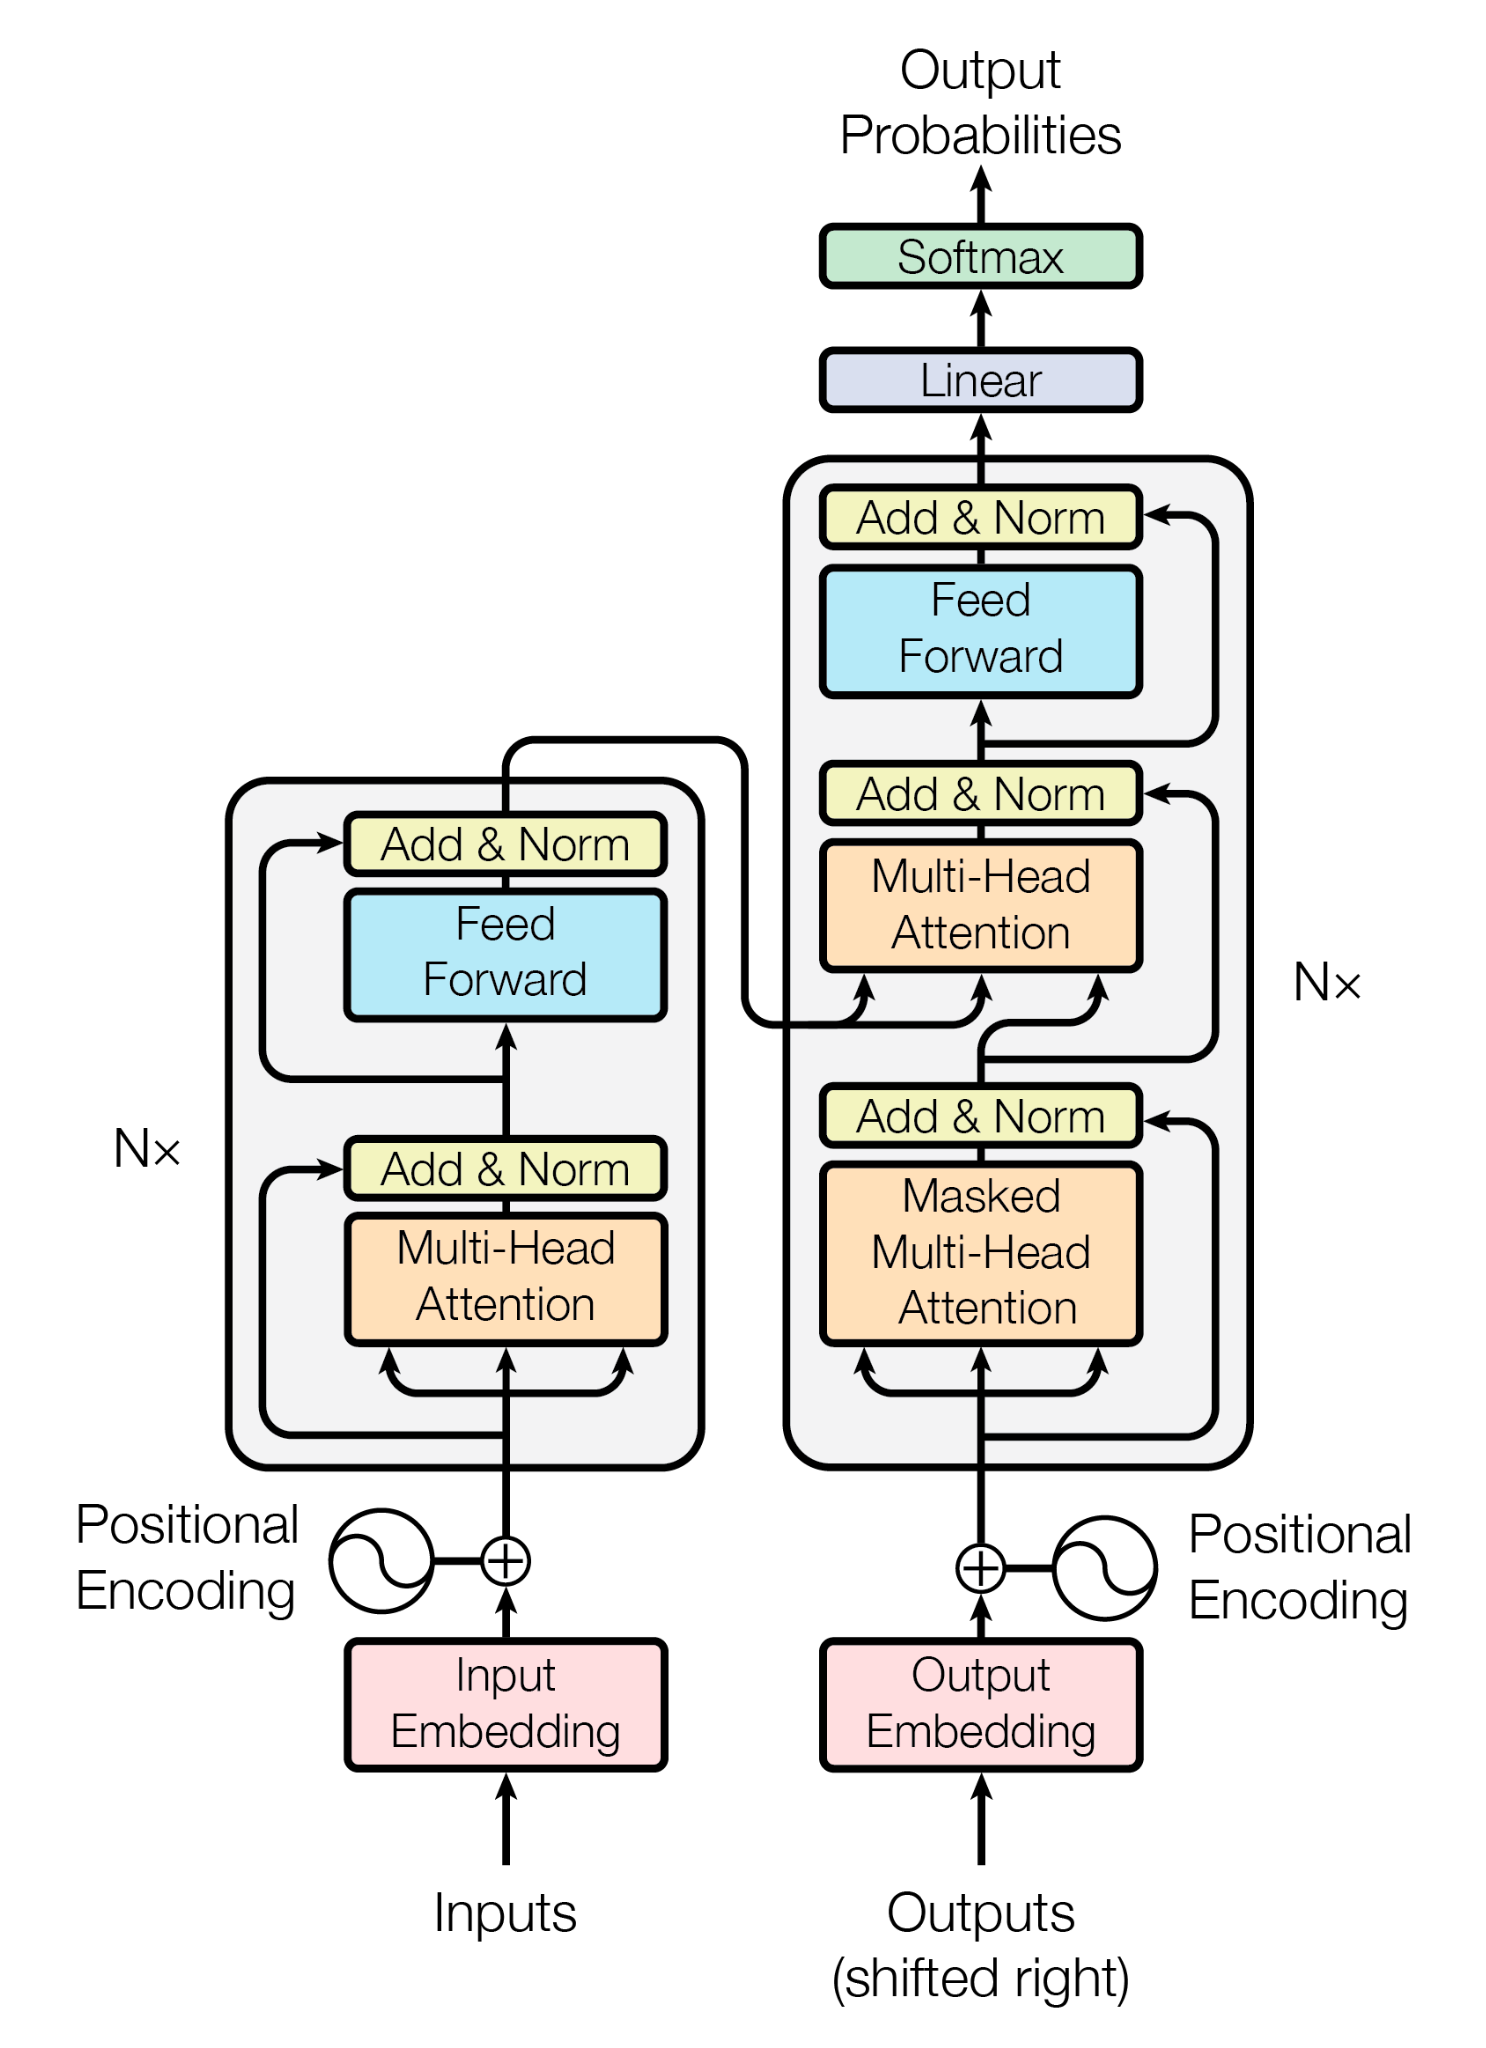
</div>
This is a network containing both an encoder (on the left) and a decoder (on the right), both of which consist of several transformer layers. In fact, there are now three commonly considered transformer-based architectures:

1. Encoder only networks (e.g. [BERT](https://github.com/google-research/bert))

2. Encoder-decoder networks (e.g. language translation, and the original "Attention is all you need" paper). Here is a schematic example of how they work (see [The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/) for further details):
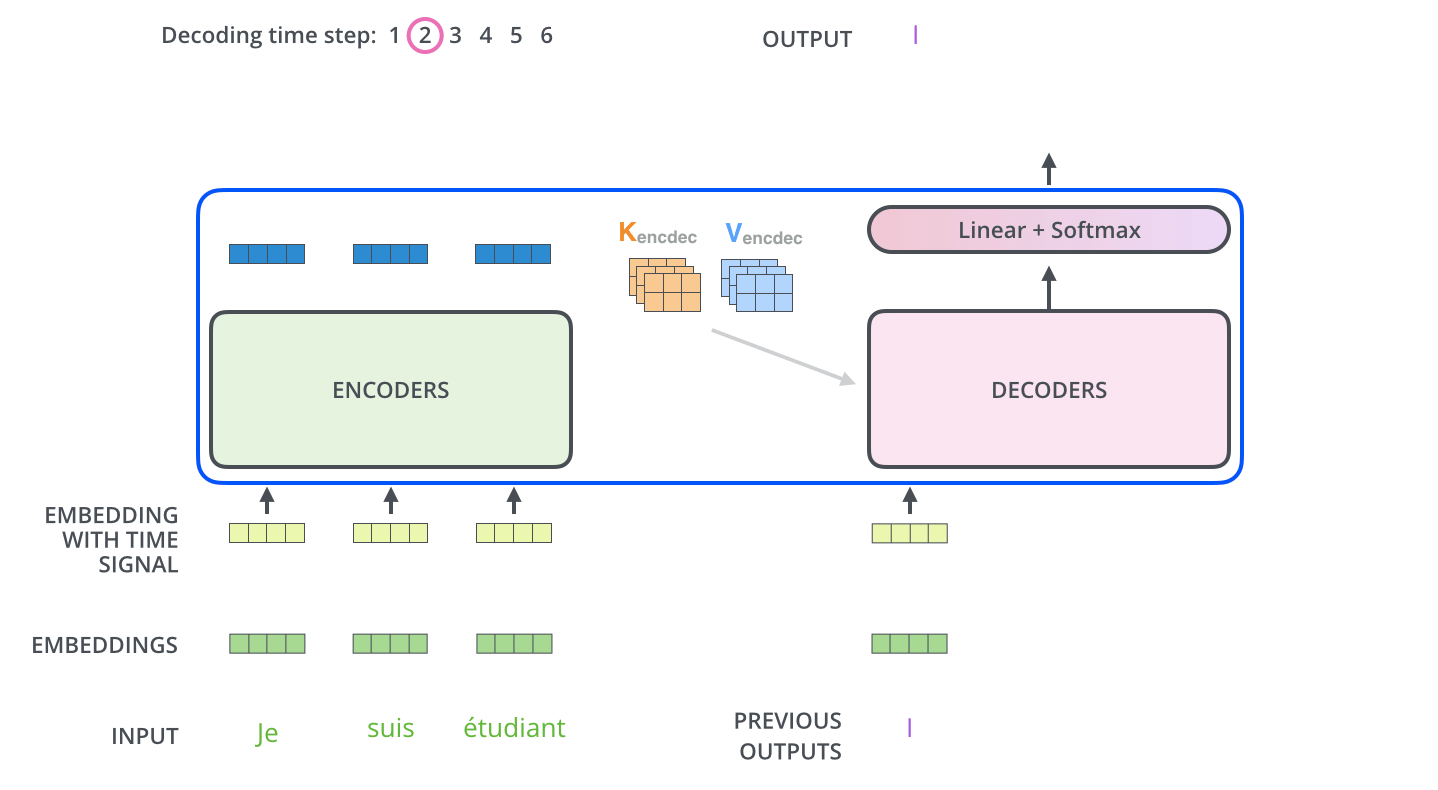

4. Decoder only networks (e.g. ChatGPT)

## Transformer layers
If we now focus in on one transformer layer, we see that it has the following key ingredients:
1. **Inputs**, which might be a sentence consisting of a sequence of $n$ words.
2. An **input embedding**, which includes a **tokenizer** that takes each word in the sentence and converts it to a number, along with an operation that converts those tokens into an _embedding_, which is a vector in some $d$ dimensional space.
3. **Positional encoding**, that adds information on the relative location of words in the sentence.
5. A **multi-head attention** layer that contextualises each word, adding information about its relationship to other words in the sentence.
6. An **add & norm** layer, that adds the input back onto the output (so that the input isn't forgotten) and normalises the values.
7. A **feed forward** layer, that is a standard fully-connected layer like we have already encountered. This layer is applied to each output token (representing a word from the original sentence, contextualised with the other words in the sentence) separately, so in fact this is $n$ parallel evaluations of a feed forward network.

## Embedding

With an input sentence consisting of $n$ words, the embedding then converts each word into a $d$-dimensional vector. We can thus consider the embedding representation of the input sequence as matrix $X \in \mathbb{R}^n \times \mathbb{R}^d$.

Let's now look at a specific example of such an embedding. We will make use of a pre-trained tokenizer from Google's BERT model:

In [2]:
from transformers import AutoTokenizer, AutoConfig
tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
config = AutoConfig.from_pretrained('google-bert/bert-base-uncased')

We now apply this to a specific sentence:

In [8]:
text = 'I love mathematics'
inputs = tokenizer(text, add_special_tokens=False, return_tensors='pt')
inputs

{'input_ids': tensor([[1045, 2293, 5597]]), 'token_type_ids': tensor([[0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1]])}

We see that each word has been converted to a number (a token). We can also convert further to an embedding (we use PyTorch for this step, use a vocabulary size of 30522 and an embedding dimension $d=4$):

In [9]:
from torch import nn
d = 4
token_embeddings = nn.Embedding(config.vocab_size, d)
token_embeddings

Embedding(30522, 4)

The result is a matrix of size $n \times d$:

In [10]:
inputs_embeds = token_embeddings(inputs.input_ids)
inputs_embeds.size()

torch.Size([1, 3, 4])

In [11]:
inputs_embeds

tensor([[[ 0.8292, -0.2905,  0.6856, -0.5059],
         [ 1.4990,  0.7064,  0.6482,  0.4701],
         [ 0.5903,  1.3525, -0.7098,  0.0763]]], grad_fn=<EmbeddingBackward0>)

## Positional encoding

The self-attention mechanism described below will treat all words equally. However, in reality the position of a word in a sentence is often imporant for inferring the meaning of the word. We therefore add a positional encoding that captures the relative location of each word in the sentence. This is typically achieved using a function that takes the position of the word, $t$, and encodes it as a $d$-dimensional vector:
$$\mathbf{p}(t) : \mathbb{N} \to \mathbb{R}^d$$
The Attention is All You Need paper uses a positional encoding made up of sine/cosine functions where the $i$-th component of $\mathbf{p}(t)$ is given by:
$$p^i(t) =
\begin{cases}
\sin(\omega_i t) & \text{for $i$ even}\\
\cos(\omega_{i-1} t) & \text{for $i$ odd}
\end{cases}$$
with $\omega_k = (10,000)^{-k/d}$. Applying this to the full input vector results in an $n \times d$ position matrix $P$ that gets linearly added to $X$ so that the output of the position encoding is $X+P$.

## Self-attention

Self-attention allows a model to focus on different parts of the input sequence (sentence) simultaneously, enabling each token to interact directly with all others regardless of their distance. This allows it to see each token in the context of all other tokens in the input sequence.

To understand self-attention, let's look more closely at the following schematic diagram taken from the "Attention is all you need" paper:

<div>
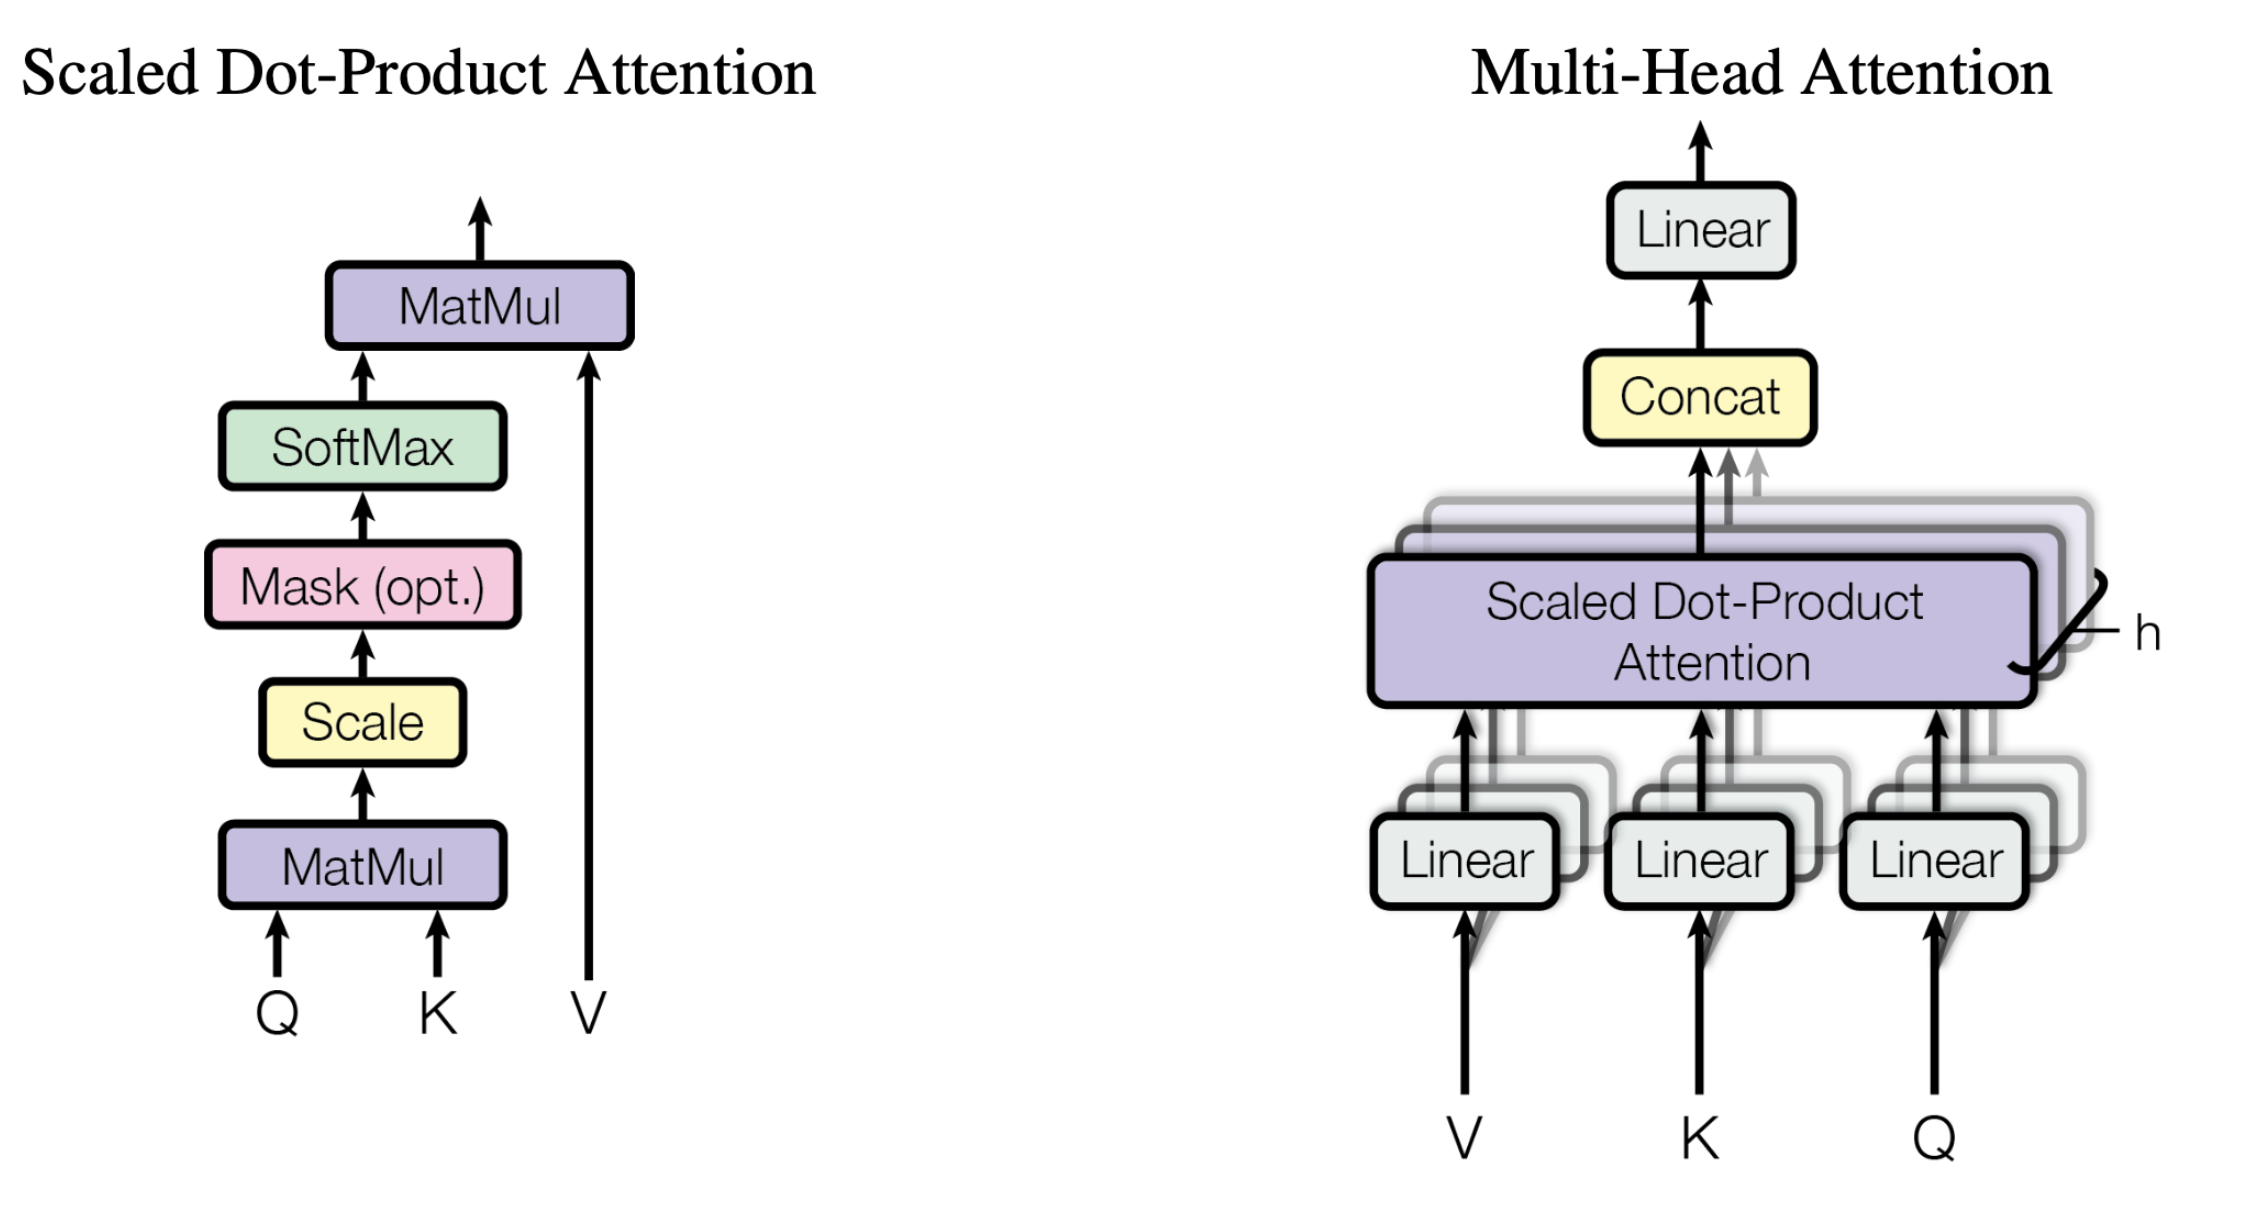
</div>

Looking first at the diagram on the left, corresponding to a single self-attention _head_, we see that it takes three input matrices, the matrix of *queries* $Q$, the matrix of *keys* $K$ and the matrix of *values* $V$. These are $n \times d$ matrices obtained from the input sequence by multipling by three $d\times d$ weight matrices $W_Q$, $W_K$ and $W_V$:
$$Q = X W_Q, \quad K = X W_K, \quad V = X W_V$$
The coefficients in these weight matrices are determined by training the network with data. The idea is that they project each word (represented by an embedding vector, i.e. a row of $X$) into a subspace that captures a certain feature of that word.


We next compute the matrix of *attention scores*, whose components are given by the dot product between each pair of query and key vectors. We have a input sequence with $n$ tokens so there are also $n$ query vectors and $n$ key vectors, and the attention score matrix will therefore be an $n\times n$ matrix. When computing the dot product it is recommended to scale by the square root of the length of the vector, $\sqrt{d}$, so that mathematically the process should be approximately independent of $d$, and also so that we avoid encountering numbers that are too large if $d$ happens to be large. We also apply the softmax function to each row of the resulting matrix, so that the rows represent probabilities (scores).

Finally, we compute the output from the attention layer by multiplying the attention score matrix by the values matrix. We interpret this as taking a linear combination of the value vectors (the rows of $V$) so that we have the word itself plus a little bit of information about each other word in the sentence, with the scores determining how much of each other word should be included based on its relevance.

The end result is an $n\times d$ self-attention matrix, $A$, which is the same size as the input but now with each of the rows representing a token along with contextual information about all other relevant tokens in the input sequence,

$$
A(Q, K, V) = \mathrm{softmax}\left(\frac{Q K^T}{\sqrt{d}}\right) V
$$

## Multi-head attention

A single attention head allows a model to focus on a single aspect of a relationship between words in a sentence. Multi-head attention then allows the model to capture multiple types of relationships in the data by projecting the queries, keys and values into multiple subspaces. Each head can learn different aspects of the sequence such as short-term dependencies or long-range interactions. For example, consider the word "bank" in a sentence. This may refer to a river bank or a financial institution. Multiple heads could focus on both grammatical structure and semantic distinction to determine which and is the correct interpretation.

Typically, if we have $h$ attention heads in a multi-head attention layer, then the dimensions of our query, key and value matrices in each attention head is reduced by a factor of $1/h$, i.e. for head $i=1, \ldots, h$ we compute $Q_i = Q W^Q_i$, $K_i = K W^K_i$ and $V_i = V W^V_i$ where the matrices $W^Q_i$, $W^K_i$ and $W^V_i$ are now $d \times (d/h)$ matrices. The calculation of the self-attention matrix for each head then proceeds exactly as in the singl-head attention case, and the final output is recombined (by concatenating and multiplying by a matrix $W^O \in \mathbb{R}^{d \times d}$) to produce a multi-head attention matrix $M$, which is again the same shape as the input:
$$
M(Q, K, V) = \mathrm{concat}(A_1, \ldots, A_h) W^O
$$
where $A_i = A(Q_i, K_i, V_i)$.

## Self-attention example

We now consider a specific small example, stepping through the calculation of the output of a single-head attention layer. Let's go back to the case where the input was the sentence "I love mathematics". This consists of three tokens which we saw above can be turned into an embedding in $d=4$ dimensions. To keep the algebra simple, instead of using the embedding we got previously let's use the embedding:
$$
X = \begin{bmatrix}
0 & 2 & 0 & 1 \\
1 & 1 & 2 & 1 \\
1 & 0 & 2 & 0
\end{bmatrix}
$$
We will also consider the weight matrices
$$
W_Q = \begin{bmatrix}
2 & 0 & 0 & 0 \\
1 & 0 & 2 & 2 \\
0 & 2 & 0 & 0 \\
1 & 1 & 1 & 0
\end{bmatrix}, \quad
W_K = \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
2 & 1 & 2 & 0 \\
1 & 0 & 0 & 1
\end{bmatrix}, \quad
W_V = \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 2 & 1 & 0 \\
0 & 1 & 1 & 2 \\
0 & 2 & 1 & 0
\end{bmatrix}.
$$
Let's first define these matrices:

In [18]:
import numpy as np
n  = 3
d  = 4
X  = np.array([[0,2,0,1],[1,1,2,1],[1,0,2,0]])
WQ = np.array([[2,0,0,0],[1,0,2,2],[0,2,0,0],[1,1,1,0]])
WK = np.array([[1,0,0,0],[0,0,0,0],[2,1,2,0],[1,0,0,1]])
WV = np.array([[1,0,0,0],[0,2,1,0],[0,1,1,2],[0,2,1,0]])

Next we compute the query, key and value matrices:

In [19]:
Q = X @ WQ
K = X @ WK
V = X @ WV
(Q,K,V)

(array([[3, 1, 5, 4],
        [4, 5, 3, 2],
        [2, 4, 0, 0]]),
 array([[1, 0, 0, 1],
        [6, 2, 4, 1],
        [5, 2, 4, 0]]),
 array([[0, 6, 3, 0],
        [1, 6, 4, 4],
        [1, 2, 2, 4]]))

Now we compute the matrix of attention scores. For this we need a softmax function:

In [40]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=1)[:,np.newaxis]

In [45]:
S = softmax((Q@K.T)/np.sqrt(d))
S

array([[8.96667933e-09, 9.70687761e-01, 2.93122305e-02],
       [7.22295087e-10, 9.52574126e-01, 4.74258731e-02],
       [9.02116571e-05, 7.30992629e-01, 2.68917160e-01]])

Finally, we compute the output from the attention layer by multiplying by $V$:

In [46]:
A = S @ V
A

array([[0.99999999, 5.88275108, 3.94137553, 3.99999996],
       [1.        , 5.81029651, 3.90514825, 4.        ],
       [0.99990979, 4.92433136, 3.46207547, 3.99963915]])

## BERT transformer-based large language model

[BERT](https://github.com/google-research/bert) (Bidirectional encoder representations from transformers) is a large language model produced by Google in 2018. 

There are different BERT models of different sizes. Let's now look in more detail at the configuration used for the Bert model we loaded above:

In [47]:
print(config)

BertConfig {
  "_name_or_path": "google-bert/bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.37.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



We now see some familiar parameters here:
* It uses a GELU activation function (`hidden_act`)
* It uses word-embedding vectors of size $d=784$ (`hidden_size`).
* It supports sentences of up to $n=512$ words (`max_position_embddings`).
* It uses a stack of 12 transformer layers (`num_attention_heads` and `num_hidden_layers`)
* It has a vobabulary of 30,522 words

BERT was trained using Wikipedia and a large sameple of book as training data. The training progressed in two ways:
* Using masked token prediction, in which a sentence is passed in with one word masked (blanked out) and the training objective is for the network to correctly fill in the missing word.
* Using next sentence prediction, in which two sentences are passed in in a randomized order and the training objective is to correctly predict which sentence should come first.

Let's use this pre-trained Bert model to fill in missing words in a sentence:

In [58]:
from transformers import pipeline

In [59]:
unmasker = pipeline('fill-mask', model='google-bert/bert-base-uncased')

Some weights of the model checkpoint at google-bert/bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [50]:
unmasker("Barry is a [MASK] lecturer.")

[{'score': 0.3520273268222809,
  'token': 2118,
  'token_str': 'university',
  'sequence': 'barry is a university lecturer.'},
 {'score': 0.07735943049192429,
  'token': 3026,
  'token_str': 'senior',
  'sequence': 'barry is a senior lecturer.'},
 {'score': 0.039070043712854385,
  'token': 3180,
  'token_str': 'regular',
  'sequence': 'barry is a regular lecturer.'},
 {'score': 0.02948855049908161,
  'token': 2280,
  'token_str': 'former',
  'sequence': 'barry is a former lecturer.'},
 {'score': 0.0289253331720829,
  'token': 2267,
  'token_str': 'college',
  'sequence': 'barry is a college lecturer.'}]

In [51]:
unmasker("Barry is the [MASK] lecturer at UCD.")

[{'score': 0.7450000047683716,
  'token': 3026,
  'token_str': 'senior',
  'sequence': 'barry is the senior lecturer at ucd.'},
 {'score': 0.03847901523113251,
  'token': 5873,
  'token_str': 'visiting',
  'sequence': 'barry is the visiting lecturer at ucd.'},
 {'score': 0.021263591945171356,
  'token': 2118,
  'token_str': 'university',
  'sequence': 'barry is the university lecturer at ucd.'},
 {'score': 0.009562605060636997,
  'token': 12372,
  'token_str': 'emeritus',
  'sequence': 'barry is the emeritus lecturer at ucd.'},
 {'score': 0.009362451732158661,
  'token': 5182,
  'token_str': 'distinguished',
  'sequence': 'barry is the distinguished lecturer at ucd.'}]

In [52]:
unmasker("Barry is the [MASK] lecturer ever.")

[{'score': 0.5927302837371826,
  'token': 6587,
  'token_str': 'youngest',
  'sequence': 'barry is the youngest lecturer ever.'},
 {'score': 0.1667504757642746,
  'token': 2190,
  'token_str': 'best',
  'sequence': 'barry is the best lecturer ever.'},
 {'score': 0.04886747896671295,
  'token': 2069,
  'token_str': 'only',
  'sequence': 'barry is the only lecturer ever.'},
 {'score': 0.03621920943260193,
  'token': 4587,
  'token_str': 'oldest',
  'sequence': 'barry is the oldest lecturer ever.'},
 {'score': 0.0326625294983387,
  'token': 2034,
  'token_str': 'first',
  'sequence': 'barry is the first lecturer ever.'}]

In [53]:
unmasker("Barry is a totally [MASK] lecturer.")

[{'score': 0.10388229042291641,
  'token': 2204,
  'token_str': 'good',
  'sequence': 'barry is a totally good lecturer.'},
 {'score': 0.10105672478675842,
  'token': 8235,
  'token_str': 'brilliant',
  'sequence': 'barry is a totally brilliant lecturer.'},
 {'score': 0.06521403044462204,
  'token': 12476,
  'token_str': 'awesome',
  'sequence': 'barry is a totally awesome lecturer.'},
 {'score': 0.03946026787161827,
  'token': 6429,
  'token_str': 'amazing',
  'sequence': 'barry is a totally amazing lecturer.'},
 {'score': 0.03164338320493698,
  'token': 11771,
  'token_str': 'boring',
  'sequence': 'barry is a totally boring lecturer.'}]

In [54]:
unmasker("She is a [MASK] teacher.")

[{'score': 0.1443595439195633,
  'token': 2082,
  'token_str': 'school',
  'sequence': 'she is a school teacher.'},
 {'score': 0.08478103578090668,
  'token': 5597,
  'token_str': 'mathematics',
  'sequence': 'she is a mathematics teacher.'},
 {'score': 0.06368272751569748,
  'token': 2189,
  'token_str': 'music',
  'sequence': 'she is a music teacher.'},
 {'score': 0.04284174367785454,
  'token': 13272,
  'token_str': 'yoga',
  'sequence': 'she is a yoga teacher.'},
 {'score': 0.039357077330350876,
  'token': 2413,
  'token_str': 'french',
  'sequence': 'she is a french teacher.'}]

In [55]:
unmasker("He is a [MASK] teacher.")

[{'score': 0.12061240524053574,
  'token': 2082,
  'token_str': 'school',
  'sequence': 'he is a school teacher.'},
 {'score': 0.0976506844162941,
  'token': 5597,
  'token_str': 'mathematics',
  'sequence': 'he is a mathematics teacher.'},
 {'score': 0.07799682766199112,
  'token': 2189,
  'token_str': 'music',
  'sequence': 'he is a music teacher.'},
 {'score': 0.0634915679693222,
  'token': 2280,
  'token_str': 'former',
  'sequence': 'he is a former teacher.'},
 {'score': 0.04751776531338692,
  'token': 3394,
  'token_str': 'retired',
  'sequence': 'he is a retired teacher.'}]

In [56]:
unmasker("I love [MASK].")

[{'score': 0.5837932825088501,
  'token': 2017,
  'token_str': 'you',
  'sequence': 'i love you.'},
 {'score': 0.15994271636009216,
  'token': 2032,
  'token_str': 'him',
  'sequence': 'i love him.'},
 {'score': 0.1470949798822403,
  'token': 2014,
  'token_str': 'her',
  'sequence': 'i love her.'},
 {'score': 0.049686919897794724,
  'token': 2009,
  'token_str': 'it',
  'sequence': 'i love it.'},
 {'score': 0.014496390707790852,
  'token': 2068,
  'token_str': 'them',
  'sequence': 'i love them.'}]

In [57]:
unmasker("I love [MASK] because I enjoy doing sums and hard calculations.")

[{'score': 0.6370635628700256,
  'token': 8785,
  'token_str': 'math',
  'sequence': 'i love math because i enjoy doing sums and hard calculations.'},
 {'score': 0.058249566704034805,
  'token': 2009,
  'token_str': 'it',
  'sequence': 'i love it because i enjoy doing sums and hard calculations.'},
 {'score': 0.03831801563501358,
  'token': 5597,
  'token_str': 'mathematics',
  'sequence': 'i love mathematics because i enjoy doing sums and hard calculations.'},
 {'score': 0.021009959280490875,
  'token': 7588,
  'token_str': 'computers',
  'sequence': 'i love computers because i enjoy doing sums and hard calculations.'},
 {'score': 0.013875370845198631,
  'token': 2068,
  'token_str': 'them',
  'sequence': 'i love them because i enjoy doing sums and hard calculations.'}]